# Transformer
:label:`sec_transformer`

We have compared CNNs, RNNs, and self-attention in Section 11.6.2. Notably, self-attention enjoys both parallel computation and the shortest maximum path length. Therefore, it is appealing to design deep architectures by using self-attention. Unlike earlier self-attention models that still rely on RNNs for input representations (Cheng et al., 2016, Lin et al., 2017, Paulus et al., 2017), the Transformer model is solely based on attention mechanisms without any convolutional or recurrent layer (Vaswani et al., 2017). Though originally proposed for sequence-to-sequence learning on text data, Transformers have been pervasive in a wide range of modern deep learning applications, such as in areas to do with language, vision, speech, and reinforcement learning.

我们对卷积神经网络（CNNs）、循环神经网络（RNNs）和自注意力机制进行了比较。值得注意的是，自注意力机制既支持并行计算，又具有最短的最大路径长度。因此，使用自注意力机制来设计深度架构颇具吸引力。与早期仍依赖 RNN 来生成输入表示的自注意力模型（Cheng 等人，2016 年；Lin 等人，2017 年；Paulus 等人，2017 年）不同，Transformer 模型 **完全基于注意力机制** ，不包含任何卷积层或循环层（Vaswani 等人，2017 年）。尽管最初是为文本数据的 *序列到序列（sequence-to-sequence）* 学习而提出的，但 Transformer 已在现代深度学习的众多应用中得到广泛应用，例如语言、视觉、语音和强化学习等领域。


## 模型

As an instance of the encoder–decoder architecture, the overall architecture of the Transformer is presented in Fig. 11.7.1. As we can see, the Transformer is composed of an encoder and a decoder. In contrast to Bahdanau attention for sequence-to-sequence learning in Fig. 11.4.2, the input (source) and output (target) sequence embeddings are added with positional encoding before being fed into the encoder and the decoder that `stack` modules based on self-attention.

Transformer作为编码器－解码器架构的一个实例，其整体架构图在 :numref:`fig_transformer`中展示。正如所见到的，Transformer是由编码器和解码器组成的。与 :numref:`fig_s2s_attention_details`中基于Bahdanau注意力实现的序列到序列的学习相比，Transformer的编码器和解码器是基于自注意力的模块 `叠加` 而成的，源（输入）序列和目标（输出）序列的 *嵌入*（embedding）表示将加上 *位置编码*（positional encoding），再分别输入到编码器和解码器中。

![transformer架构](../images/transformer.png)

### 编码器
上图概述了Transformer的架构。从宏观角度来看，Transformer的编码器是由 $n$ 个相同的层叠加而成的，每个层都有两个子层（子层表示为 $\mathrm{sublayer}$ ）。
* 第一个子层是 *多头自注意力*（multi-head self-attention）汇聚；
* 第二个子层是 *基于位置的前馈网络*（positionwise feed-forward network）。
* 具体来说，在计算编码器的自注意力时，查询、键和值都来自前一个编码器层的输出。
* 受残差网络的启发，两个子层都采用了 *残差连接*（residual connection）。在Transformer中，对于序列中任何位置的任何输入 $\mathbf{x} \in \mathbb{R}^d$，都要求满足 $\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$，以便残差连接满足 $\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$。
* 在残差连接的加法计算之后，紧接着 apply *层规范化*（layer normalization）。因此，输入序列对应的每个位置，Transformer 编码器都将输出一个 $d$ 维表示向量。

### 解码器

Transformer解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为 *编码器－解码器注意力*（encoder-decoder attention）层。
* 在编码器－解码器注意力中，`查询` 来自前一个解码器层的输出，而 `键` 和 `值` 来自整个编码器的输出。
* 在解码器自注意力中，`查询` 、`键` 和 `值` 都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种 *掩蔽*（masked）注意力保留了 *自回归*（auto-regressive）属性，确保预测仅依赖于已生成的输出 tokens。

在此之前已经描述并实现了基于缩放点积多头注意力和位置编码 。接下来将实现Transformer模型的剩余部分。

In [6]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 基于位置的前馈网络

基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是 *基于位置的*（positionwise）的原因。在下面的实现中，输入`X`的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，`ffn_num_outputs`）的输出张量。


In [27]:
class PositionWiseFFN(nn.Module):  #@save
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        # 第一个全连接层 (dense1)
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        # ReLU激活函数
        self.relu = nn.ReLU()
        # 第二个全连接层 (dense2)
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

因为用同一个多层感知机对所有位置上的输入进行变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。下面的示例体现了：
*  PositionWiseFFN 能够正确处理指定形状的输入，并产生预期形状的输出。
*  "基于位置的前馈网络"对所有位置应用相同变换的特点。

In [46]:
# 第一个全连接层的隐藏单元数：4
# 是第二个全连接层输出维度：8
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.2548, -0.2632, -0.6357,  0.1690, -0.2262,  0.2123, -0.5922,  0.1841],
        [-0.2548, -0.2632, -0.6357,  0.1690, -0.2262,  0.2123, -0.5922,  0.1841],
        [-0.2548, -0.2632, -0.6357,  0.1690, -0.2262,  0.2123, -0.5922,  0.1841]],
       grad_fn=<SelectBackward0>)

## 残差连接和层规范化

Now let’s focus on the “add & norm” component. As we described at the beginning of this section, this is a residual connection immediately followed by layer normalization. Both are key to effective deep architectures.

现在让我们关注 *加法和规范化*（add&norm）组件。正如在本节开头所述，这是由 `残差连接` (有助于缓解 *深度* 网络中的梯度消失问题，使网络更容易训练。) 和紧随其后的 `层规范化` 组成的。两者都是构建有效的深度架构的关键。

We explained how batch normalization recenters and rescales across the examples within a minibatch. Layer normalization is the same as batch normalization except that the former normalizes across the feature dimension, thus enjoying benefits of scale independence and batch size independence. Despite its pervasive applications in computer vision, batch normalization is usually empirically less effective than layer normalization in natural language processing tasks, where the inputs are often variable-length sequences.

我们解释了批量归一化是如何在小批量内的示例中重新定位和重新缩放的。层规范化和批量规范化的目标相同，但层规范化是基于 `特征维度` 进行规范化，从而具有 `尺度独立性` 和 `批量大小独立性` 的优势。尽管批量归一化在计算机视觉中应用广泛，但在自然语言处理任务中，由于输入通常是可变长度的序列，所以批量归一化通常在经验上不如层归一化有效。

以下代码对比不同维度的层规范化和批量规范化的效果。


In [50]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print(f"X:\n{X}")
# Compute mean and variance(方差) from X in the training mode
print('\nlayer norm [每个样本]:\n', ln(X), '\nbatch norm [每个特征（dim）]:\n', bn(X))

X:
tensor([[1., 2.],
        [2., 3.]])

layer norm [每个样本]:
 tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm [每个特征（dim）]:
 tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


现在可以[**使用残差连接和层规范化**]来实现`AddNorm`类。暂退法也被作为正则化方法使用。


In [29]:
class AddNorm(nn.Module):  #@save
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    # X 是原始输入（残差连接的"捷径"部分）OR "之前的小net"
    # Y 是经过子层（如注意力或前馈网络）处理后的输出
    def forward(self, X, Y):
        residual_conn = self.dropout(Y) + X
        return self.ln(residual_conn)

残差连接要求两个输入的形状相同，以便[**加法操作后输出张量的形状相同**]。


In [54]:
add_norm = AddNorm(4, 0.5)
X, Y = (2, 3, 4), (2, 3, 4)
result = add_norm(torch.ones(X), torch.ones(Y))
d2l.check_shape(result, X)
print(result)

tensor([[[-1.0000, -1.0000,  1.0000,  1.0000],
         [-0.5773, -0.5773, -0.5773,  1.7320],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[-1.0000,  1.0000,  1.0000, -1.0000],
         [ 1.0000, -1.0000,  1.0000, -1.0000],
         [-0.5773, -0.5773, -0.5773,  1.7320]]],
       grad_fn=<NativeLayerNormBackward0>)


## 编码器

With all the essential components to assemble the Transformer encoder, let’s start by implementing a single layer within the encoder. The following TransformerEncoderBlock class contains two sublayers: multi-head self-attention and positionwise feed-forward networks, where a residual connection followed by layer normalization is employed around both sublayers.

有了组成Transformer编码器的基础组件，现在可以先 **实现编码器中的一个层**。下面的 `TransformerEncoderBlock` 类包含两个子层：`多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。`


In [31]:
class TransformerEncoderBlock(nn.Module):  #@save
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

正如从代码中所看到的，[**Transformer编码器中的任何层都不会改变其输入的形状**]。


In [55]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(num_hiddens=24, ffn_num_hiddens=48, num_heads=8, dropout=0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)

Transformer编码器的实现

![**Transformer编码器的实现**](../images/encoder.png)

下面实现的[**Transformer编码器**]的代码中，堆叠了`num_layers`个`EncoderBlock`类的实例。由于这里使用的是值范围在$-1$和$1$之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。

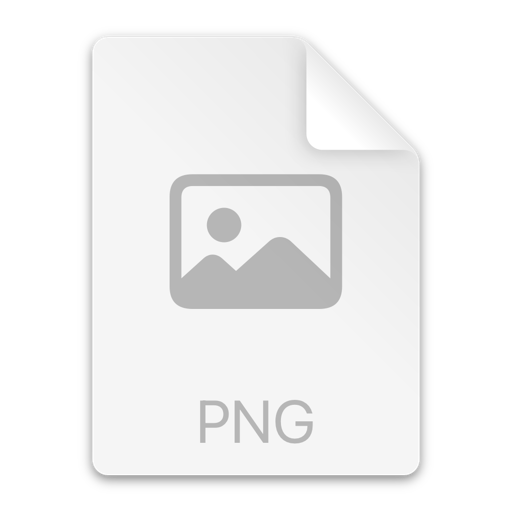

In [34]:
class TransformerEncoder(d2l.Encoder):  #@save
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i),
                                 TransformerEncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

下面我们指定了超参数来[**创建一个两层的Transformer编码器**]。
Transformer编码器输出的形状是（批量大小，时间步数目，`num_hiddens`）。


In [63]:
encoder = TransformerEncoder(vocab_size=200, num_hiddens=24, ffn_num_hiddens=48, num_heads=8, num_blks=2, dropout=0.5)
result = encoder(torch.ones((2, 100), dtype=torch.long), valid_lens)
d2l.check_shape(result, (2, 100, 24))
print(result[:,:3,:12])

tensor([[[-0.3712,  0.4217, -0.3819, -0.3203,  1.0472, -1.1146, -0.6492,
          -1.5521,  0.2094,  1.6814, -0.2306,  1.1291],
         [ 1.3911, -0.1566,  0.4664, -0.0746, -0.3578, -0.3825, -1.4952,
          -1.0883, -0.9498, -0.2098,  0.0787,  0.5247],
         [-0.6650,  0.5379,  1.0829, -1.5305, -0.2537,  0.1482, -0.1508,
           0.8211, -0.3980, -0.2021,  0.1482,  0.6159]],

        [[-1.5035, -0.6175,  0.4807, -0.3476,  0.4121,  1.3526, -0.0678,
           0.9257, -0.5117, -0.5485, -0.5081,  0.1294],
         [-0.1782, -0.5466, -0.1030, -0.2974, -0.3510,  0.0547,  0.6450,
           0.3175, -1.8770,  0.0749,  0.3027,  1.8593],
         [-0.5969,  0.3908,  2.2818, -1.1053, -0.7902, -0.6110, -0.1831,
           0.5691, -0.3272,  0.4578,  0.6704,  1.8118]]],
       grad_fn=<SliceBackward0>)


## 解码器

![**Transformer解码器的实现**](../images/decoder.png)

As shown in Fig. 11.7.1, the Transformer decoder is composed of multiple identical layers. Each layer is implemented in the following TransformerDecoderBlock class, which contains three sublayers:
* sublayer 1: decoder self-attention
* sublayer 2: encoder–decoder attention
* sublayer 3: positionwise feed-forward networks
* These sublayers employ a residual connection around them followed by layer normalization.

Transformer解码器也是由多个相同的层组成，在`TransformerDecoderBlock` 类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。

### sublayer 1: decoder self-attention (masked multi-head attention)

As we described earlier in this section, in the masked multi-head decoder self-attention (the first sublayer), queries, keys, and values all come from the outputs of the previous decoder layer. When training sequence-to-sequence models, tokens at all the positions (time steps) of the output sequence are known. However, during prediction the output sequence is generated token by token; thus, at any decoder time step only the generated tokens can be used in the decoder self-attention. To preserve autoregression in the decoder, its masked self-attention specifies dec_valid_lens so that any query only attends to all positions in the decoder up to the query position.

正如在本节前面所述，在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。关于*序列到序列模型*（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的 token 是逐个生成的。因此，在任何解码器时间步中，只有生成的 token 才能用于解码器的自注意力计算中。为了在解码器中保留自回归性，其掩码自注意力机制设定了参数 `dec_valid_lens`，以便任何查询都只 `关注` 解码器中所有已经生成 token 的位置（截止该查询位置为止）来进行注意力计算。


In [25]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder 第i个块
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        # 从 state 中提取编码器输出和有效长度
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed at the same time, so state[2][self.i] is None as initialized.
        # When decoding any output sequence token by token during prediction
        # state[2][self.i] contains representations of the decoded output at the i-th block up to the current time step

        # 训练阶段，输出序列的所有词元都在同一时间处理， 因此 state[2][self.i] 初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None: # 第一个时间步
            key_values = X
        else:
            # 将 上一个时间步的 X 与 当前时间步的 X 在 1 维拼接起来 ==》 截止到当前时间步的所有输入 X的拼接 ==》 只 `关注` 解码器中 ‘截止到该查询位置为止’ 所有已经生成的 token
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every row is [1, 2, ..., num_steps]
            # training 时 只 `关注` 解码器中 ‘截止到该查询位置为止’ 所有已经生成的 token
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # Masked self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)

        # Encoder-decoder attention. Shape of enc_outputs: (batch_size, num_steps, num_hiddens)
        # enc_outputs： 编码器的输出
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)

        # Positionwise feed-forward network
        return self.addnorm3(Z, self.ffn(Z)), state

为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，[**编码器和解码器的特征维度都是`num_hiddens`。**]


In [106]:
decoder_blk = TransformerDecoderBlock(num_hiddens=24, ffn_num_hiddens=48, num_heads=8, dropout=0.5, i=0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
result = decoder_blk(X, state)
d2l.check_shape(result[0], X.shape)

现在我们构建了由`num_layers`个`DecoderBlock`实例组成的完整的[**Transformer解码器**]。最后，通过一个全连接层计算所有`vocab_size`个可能的输出词元的预测值。解码器的自注意力权重和编码器解码器注意力权重都被存储下来，方便日后可视化的需要。


In [122]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))

        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]

        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights

        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 训练

依照Transformer架构来实例化编码器－解码器模型。在这里，指定Transformer的编码器和解码器都是2层，都使用4头注意力。与 :numref:`sec_seq2seq_training`类似，为了进行序列到序列的学习，下面在“英语－法语”机器翻译数据集上训练Transformer模型。


In [125]:
# 加载英语-法语机器翻译数据集，设置批量大小为128
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)
decoder = TransformerDecoder(len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.001)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)

训练结束后，使用Transformer模型[**将一些英语句子翻译成法语**]，并且计算它们的BLEU分数。


In [130]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

preds, _ = model.predict_step(batch=data.build(engs, fras), device=d2l.try_gpu(), num_steps=data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    # 将预测的token ID转换回文本token
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu, 'f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

print(data.num_steps)

go . => ['va', '!'], bleu, 1.000
i lost . => ["j'ai", 'perdu', '.'], bleu, 1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu, 0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu, 1.000
9


当进行最后一个英语到法语的句子翻译工作时，让我们[**可视化Transformer的注意力权重**]。编码器自注意力权重的形状为（编码器层数，注意力头数，`num_steps`或查询的数目，`num_steps`或“键－值”对的数目）。


In [134]:
_, dec_attention_weights = model.predict_step(data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
d2l.check_shape(enc_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))
print(enc_attention_weights.shape)

torch.Size([2, 4, 9, 9])


在编码器的自注意力中，查询和键都来自相同的输入序列。因为填充词元是不携带信息的，因此通过指定输入序列的有效长度可以避免查询与使用填充词元的位置计算注意力。

下图逐行呈现了两层多头注意力的权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力。


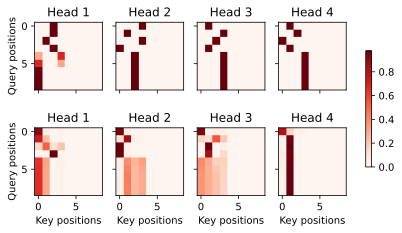

In [133]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

为了可视化解码器的自注意力权重和 “编码器－解码器” 的注意力权重，我们需要完成更多的数据操作工作。例如用零填充被掩蔽住的注意力权重。

值得注意的是，`解码器` 的自注意力权重和 “编码器－解码器” 的注意力权重都有相同的查询：即以 *序列开始词元*（beginning-of-sequence,BOS）打头，再与后续输出的词元共同组成序列。


In [42]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
shape = (-1, 2, num_blks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

d2l.check_shape(dec_self_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))
d2l.check_shape(dec_inter_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算。


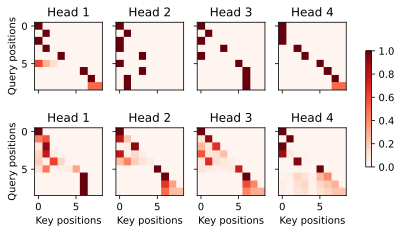

In [43]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

与编码器的自注意力的情况类似，通过指定输入序列的有效长度，输出序列的查询不会与输入序列中填充位置的词元进行注意力计算。


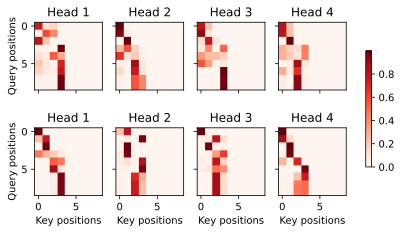

In [44]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

尽管Transformer架构是为了 *序列到序列* 的学习而提出的，但正如本书后面将提及的那样，Transformer编码器或Transformer解码器通常被单独用于不同的深度学习任务中。





## 预测

* 预测第 t + 1 个输出时
* 解码器中输入前 t 个预测值
* 在自注意力中，输入序列的有效长度被限制为 t；前 t 个预测值作为 key 和 value, 第 t 个预测值还作为 query

## 小结

1. [x] Transformer 是编码器－解码器架构的一个实践。
2. [x] Transformer 是一个纯使用注意力的编码-解码器模型。
3. [x] Transformer 前置 _位置编码（Positional encoding）_ 和 _Embedding_
4. [x] Transformer 中，_多头自注意力_ 用于表示 _输入序列_ 和 _输出序列_，不过解码器必须通过 *掩蔽机制* 来保留自回归属性。
5. [x] 编码器和解码器都有 n 个 transformer 块，每个块中:
   * 基于位置的前馈网络（Positionwise FFN）使用同一个多层感知机，作用是对所有序列位置的表示进行转换。
   * 残差连接 和 层归一化 是训练非常深度模型的重要工具。
